### A Very simple RNN 
The code and the example is taken from http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/LSTM.php

In [21]:
import numpy as np
import theano
import theano.tensor as T

dtype=theano.config.floatX

In [22]:
sigma = lambda x: 1 / (1 + T.exp(-x))


# for the other activation function we use the tanh
act = T.tanh

# sequences: x_t
# prior results: h_tm1, c_tm1
# non-sequences: W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xy, W_hy, W_cy, b_y
def one_lstm_step(x_t, h_tm1, c_tm1, W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xy, W_ho, W_cy, b_o, W_hy, b_y):
    i_t = sigma(theano.dot(x_t, W_xi) + theano.dot(h_tm1, W_hi) + theano.dot(c_tm1, W_ci) + b_i)
    f_t = sigma(theano.dot(x_t, W_xf) + theano.dot(h_tm1, W_hf) + theano.dot(c_tm1, W_cf) + b_f)
    c_t = f_t * c_tm1 + i_t * act(theano.dot(x_t, W_xc) + theano.dot(h_tm1, W_hc) + b_c) 
    o_t = sigma(theano.dot(x_t, W_xo)+ theano.dot(h_tm1, W_ho) + theano.dot(c_t, W_co)  + b_o)
    h_t = o_t * act(c_t)
    y_t = sigma(theano.dot(h_t, W_hy) + b_y) 
    return [h_t, c_t, y_t]

In [14]:
#TODO: Use a more appropriate initialization method
def sample_weights(sizeX, sizeY):
    values = np.ndarray([sizeX, sizeY], dtype=dtype)
    for dx in xrange(sizeX):
        vals = np.random.uniform(low=-1., high=1.,  size=(sizeY,))
        #vals_norm = np.sqrt((vals**2).sum())
        #vals = vals / vals_norm
        values[dx,:] = vals
    _,svs,_ = np.linalg.svd(values)
    #svs[0] is the largest singular value                      
    values = values / svs[0]
    return values  

In [23]:
n_in = 7 # for embedded reber grammar
n_hidden = n_i = n_c = n_o = n_f = 10
n_y = 7 # for embedded reber grammar

# initialize weights
# i_t and o_t should be "open" or "closed"
# f_t should be "open" (don't forget at the beginning of training)
# we try to archive this by appropriate initialization of the corresponding biases 

W_xi = theano.shared(sample_weights(n_in, n_i))  
W_hi = theano.shared(sample_weights(n_hidden, n_i))  
W_ci = theano.shared(sample_weights(n_c, n_i))  
b_i = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_i)))
W_xf = theano.shared(sample_weights(n_in, n_f)) 
W_hf = theano.shared(sample_weights(n_hidden, n_f))
W_cf = theano.shared(sample_weights(n_c, n_f))
b_f = theano.shared(np.cast[dtype](np.random.uniform(0, 1.,size = n_f)))
W_xc = theano.shared(sample_weights(n_in, n_c))  
W_hc = theano.shared(sample_weights(n_hidden, n_c))
b_c = theano.shared(np.zeros(n_c, dtype=dtype))
W_xo = theano.shared(sample_weights(n_in, n_o))
W_ho = theano.shared(sample_weights(n_hidden, n_o))
W_co = theano.shared(sample_weights(n_c, n_o))
b_o = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_o)))
W_hy = theano.shared(sample_weights(n_hidden, n_y))
b_y = theano.shared(np.zeros(n_y, dtype=dtype))

c0 = theano.shared(np.zeros(n_hidden, dtype=dtype))
h0 = T.tanh(c0)

params = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y, c0]

In [24]:
#first dimension is time

#input 
v = T.matrix(dtype=dtype)

# target
target = T.matrix(dtype=dtype)

In [25]:
# hidden and outputs of the entire sequence
[h_vals, _, y_vals], _ = theano.scan(fn=one_lstm_step, 
                                  sequences = dict(input=v, taps=[0]), 
                                  outputs_info = [h0, c0, None ], # corresponds to return type of fn
                                  non_sequences = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y] )

In [26]:
cost = -T.mean(target * T.log(y_vals)+ (1.- target) * T.log(1. - y_vals))

In [34]:
# learning rate
lr = np.cast[dtype](.1)
learning_rate = theano.shared(lr)

In [35]:
gparams = []
for param in params:
  gparam = T.grad(cost, param)
  gparams.append(gparam)

updates=[]
for param, gparam in zip(params, gparams):
    updates.append((param, param - gparam * learning_rate))

In [36]:
import reberGrammar
train_data = reberGrammar.get_n_embedded_examples(50)

In [37]:
len(train_data[21][0]),len(train_data[21][1]), train_data[21]
# 



(18,
 18,
 ([array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
   array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
   array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
   array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
   array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
   array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
   array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.])],
  [array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
   array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
   array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.]),
  

In [38]:
learn_rnn_fn = theano.function(inputs = [v, target],
                               outputs = cost,
                               updates = updates)

/usr/local/lib/python2.7/dist-packages/theano/tensor/opt.py:2326: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (replace_x == replace_y and
/usr/local/lib/python2.7/dist-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [39]:
nb_epochs=20
train_errors = np.ndarray(nb_epochs)
def train_rnn(train_data):      
  for x in range(nb_epochs):
    error = 0.
    print(x)
    for j in range(len(train_data)):  
        index = np.random.randint(0, len(train_data))
        i, o = train_data[index] #Ein Beispiel im Trainingset
        train_cost = learn_rnn_fn(i, o)
        error += train_cost
    train_errors[x] = error 
    
train_rnn(train_data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(0.0, 50)

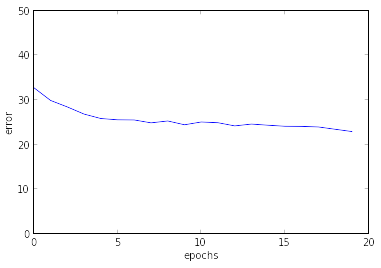

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.arange(nb_epochs), train_errors, 'b-')
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim(0., 50)

In [41]:
target

<TensorType(float32, matrix)>

In [42]:
y_vals

for{cpu,scan_fn}.2